In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.data.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score

In [48]:
# Read from csv (without second list in daughter columns)
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

In [49]:
# Columns including daughter kinematics
train_d_cols = list(train_df[train_df.columns[train_df.columns.str.contains("_Daughters")]])
test_d_cols = list(test_df[test_df.columns[test_df.columns.str.contains("_Daughters")]])

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + ['Jet0_Eta', 'Jet0_PT']
test_f_cols = test_d_cols + ['Jet1_Eta', 'Jet1_PT']

In [50]:
# Duplicate Jet PT and Eta elements as a list the same length as the number of daughters in each row
def duplicate(df, cols, n_col):
    def duplicate_value(row, col, n_col):
        value = row[col]
        if isinstance(value, (float, int)):
            num_daughters = row[n_col]
            return [value] * num_daughters
        return value

    for col in cols:
        df[col] = df.apply(lambda row: duplicate_value(row, col, n_col), axis=1)
    return df

# Converts string into list of floats (already duplicated and dropped second array)
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [52]:
# Duplicate and preprocess daughter columns
train_df = duplicate(train_df, ['Jet0_PT', 'Jet0_Eta', 'IsB'], 'Jet0_nDaughters')
test_df = duplicate(test_df, ['Jet1_PT', 'Jet1_Eta', 'IsB'], 'Jet1_nDaughters')

# Clean up data from str to list of floats
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Select first 500 sig aand first 500 bgk data for quicker training
cut_train_df = pd.concat([train_df.head(500), train_df.iloc[100000:100500]]) 
cut_test_df = pd.concat([test_df.head(500), test_df.iloc[100000:100500]])

In [76]:
# Gets node features to create x tensor
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

# Creates a data object of each df
def create_data_object(df, features_cols):
    
    df = df.sample(frac=1).reset_index(drop=True)
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        
    return data_list

In [77]:
train_data = create_data_object(cut_train_df, train_f_cols)
test_data = create_data_object(cut_test_df, test_f_cols)

In [78]:
# Load data
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# Training Model

In [85]:
# Define GNN model

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.sigmoid(x)
        x = self.lin(x)
        return x
            
model = GNN()

In [86]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
    return loss.item()

def test():
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            _, pred = out.max(dim=1)
            correct = pred.eq(data.y).sum().item()
            total_correct += correct
            total_samples += len(data.y)

    accuracy = total_correct / total_samples
    return accuracy

for epoch in range(10):
    loss = train()
    acc = test()

    print(f'Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 1, Loss: 0.7472, Accuracy: 0.4971
Epoch: 2, Loss: 0.7342, Accuracy: 0.4978
Epoch: 3, Loss: 0.7236, Accuracy: 0.4970
Epoch: 4, Loss: 0.7204, Accuracy: 0.5009
Epoch: 5, Loss: 0.7329, Accuracy: 0.5029
Epoch: 6, Loss: 0.7201, Accuracy: 0.5039
Epoch: 7, Loss: 0.7185, Accuracy: 0.5015
Epoch: 8, Loss: 0.7239, Accuracy: 0.4962
Epoch: 9, Loss: 0.7101, Accuracy: 0.5054
Epoch: 10, Loss: 0.7314, Accuracy: 0.5047


# ROC Curve and AUC

In [64]:
y_true = [] # class values (0 or 1)
y_scores = [] # predicted probabilities

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        _, pred = out.max(dim=1)
        y_true.append(data.y.numpy().flatten())
        y_scores.append(out[:, 1].detach().numpy())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [65]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

In [66]:
# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

print(f'Background Rejection: {back_rej}')
print(f'Signal Efficiency: {sig_eff}')
print(f'AUC: {auc}')

Background Rejection: [1.00000000e+00 1.00000000e+00 9.99585120e-01 ... 8.29760752e-04
 1.38293459e-04 0.00000000e+00]
Signal Efficiency: [0.00000000e+00 1.40075641e-04 1.40075641e-04 ... 9.99439697e-01
 1.00000000e+00 1.00000000e+00]
AUC: 0.5132086815747879


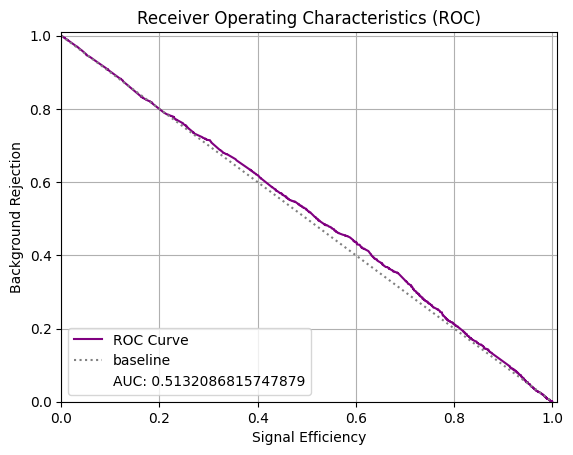

In [67]:
# Plot ROC Curve and show AUC
plt.plot(back_rej, sig_eff, label='ROC Curve', color='purple')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.plot([], [], ' ', label=f'AUC: {auc}')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()